Putting the sequential feeding of data into the RNN part of the RNN module (how else are we going to be able to train our thalamus layer??). Implements strucutre of RNN then linear layer then RNN. DOES NOT RUN BUT I AM TIRED AND AM GIVING UP

In [1]:
from scipy.io import loadmat
import numpy as np
import torch 


In [2]:
monkey_data = loadmat('monkey_data.mat') 
visual_data = monkey_data['inp'][0]
muscle_data = monkey_data['targ'][0]


In [3]:
test = np.zeros((502, 2))
for i, data in enumerate(visual_data):
    test[i] = data.shape

print(test[:,1].max())

341.0


In [4]:
batch_size = visual_data.shape[0] # N, 502
trial_len = int(test[:,1].max()) # visual_data[0].shape[1] # T, 298 
in_dim = visual_data[0].shape[0] # L, 21
out_dim = muscle_data[0].shape[0] # O, 50

hid_dim = 100
num_layers = 3

In [5]:
new_visual_data = np.zeros((batch_size, trial_len, in_dim))

for i, data in enumerate(visual_data):
    new_visual_data[i, 0:visual_data[i].shape[1], :] = visual_data[i].transpose()
print(new_visual_data.shape)

(502, 341, 21)


In [6]:
import math
from sklearn.model_selection import train_test_split
from sklearn.utils import gen_batches
# np.random.seed()

 # shuffling was somehow change 
train_idx, test_idx = train_test_split(
     range(batch_size), 
     test_size=0.2, 
     shuffle=True )

train_input = np.zeros((int(batch_size * .8), trial_len, in_dim))
train_output = np.zeros((int(batch_size * .8), trial_len, out_dim))
test_input = np.zeros((int(np.ceil(batch_size * .2)), trial_len, in_dim))
test_output = np.zeros((int(np.ceil(batch_size * .2)), trial_len, out_dim))
train_ind = 0
test_ind = 0
for i, data in enumerate(visual_data):
     if i in train_idx:
       # train_input[train_ind, 0:visual_data[i].shape[1], :] = visual_data[i].transpose()
       train_input[train_ind, -visual_data[i].shape[1]:, :] = visual_data[i].transpose()
       train_output[train_ind, -visual_data[i].shape[1]:, :] = muscle_data[i].transpose()
       train_ind += 1
     else:
        test_input[test_ind, -visual_data[i].shape[1]:, :] = visual_data[i].transpose()
        test_output[test_ind, -visual_data[i].shape[1]:, :] = muscle_data[i].transpose()
        test_ind += 1





- ReTanh activation function --> yes
- rate regularization: 1e-1 --> yes
- weight regularization: 1e-5 --> yes
- intermodule sparsity: 0.1 --> no
- Hessian free optimization --> yes
- birdirectional --> no

In [7]:
def hardcore_loss(output, target, model_params):
    firing_reg = 1e-1
    weight_reg = 1e-5
    weight_sum = torch.zeros((1))
    for name, param in model_params: 
        if "weight" in name:
            weight_sum += torch.sum(param **  2)

    loss = torch.sum((output - target)**2) + firing_reg * torch.sum(output ** 2) + weight_reg * weight_sum
    return loss

In [16]:
from torch import nn
import torch.nn.utils.prune as prune
import torch.nn.functional as F

from mrnn import MilliesRNN
from hessianfree import HessianFree

learning_rate = 0.001
hessian = False
hardcore = True


model = MilliesRNN(in_dim, hid_dim, out_dim, True)
module1 = model.h2o
prune.random_unstructured(module1, name="weight", amount=0.9)
module2 = model.thal
prune.random_unstructured(module2, name="weight", amount=0.9)

if hardcore:
    criterion = hardcore_loss
else:
    criterion = nn.MSELoss() 

if hessian:
    optimizer = HessianFree(model.parameters(), use_gnm=True, verbose=True)
else:
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

num_epochs = 5
print_interval = 100
loss_error = []

preds = np.zeros((int(batch_size * .8), trial_len, out_dim))

model.train()
for epoch in range(num_epochs):
    batches = []
    shuffed = np.arange(0,401)
    np.random.shuffle(shuffed)
    for i in range(5):
        idx = shuffed[int((train_input.shape[0]/5)*i):int((train_input.shape[0]/5)*(i+1))]
        
        batches.append(idx)
    
    for j, batch in enumerate(batches):
        
        optimizer.zero_grad()

        outputs = model(torch.from_numpy(train_input[batch]).to(torch.float32))   

        if hardcore:
            loss = criterion(outputs, torch.from_numpy(train_output[batch]).to(torch.float32), model.named_parameters())
        else:
            loss = criterion(outputs, torch.from_numpy(train_output[batch]).to(torch.float32))
        
            
        nn.utils.clip_grad_norm_(model.parameters(), 1)

        def closure():
            gen_output = model(torch.from_numpy(train_input[batch]).to(torch.float32))
            loss = criterion(gen_output, torch.from_numpy(train_output[batch]).to(torch.float32), model.named_parameters())
            loss.backward(create_graph=True)
            return loss, gen_output
        
        if hessian:
            optimizer.step(closure, M_inv=None)
        else: # gradient descent
            loss.backward()
            optimizer.step()

        loss_error.append(loss.item())
        # if i == 0 or (i + 1) % print_interval == 0:
        print(
            f"Epoch [{epoch + 1}/{num_epochs}], "
            f"Step [{j + 1}/{len(train_output)}], "
            f"Loss: {loss.item():.4f}"
        )
        



Epoch [1/5], Step [1/401], Loss: 30062.4199
Epoch [1/5], Step [2/401], Loss: 29753.5840
Epoch [1/5], Step [3/401], Loss: 27699.1660
Epoch [1/5], Step [4/401], Loss: 27109.9766
Epoch [1/5], Step [5/401], Loss: 27609.3730
Epoch [2/5], Step [1/401], Loss: 26184.9863
Epoch [2/5], Step [2/401], Loss: 25406.1660
Epoch [2/5], Step [3/401], Loss: 25089.3867
Epoch [2/5], Step [4/401], Loss: 26276.5938
Epoch [2/5], Step [5/401], Loss: 24824.7910
Epoch [3/5], Step [1/401], Loss: 25415.6953
Epoch [3/5], Step [2/401], Loss: 24013.0195
Epoch [3/5], Step [3/401], Loss: 24070.3926
Epoch [3/5], Step [4/401], Loss: 23692.6777
Epoch [3/5], Step [5/401], Loss: 22946.0449
Epoch [4/5], Step [1/401], Loss: 22646.7363
Epoch [4/5], Step [2/401], Loss: 22613.0586
Epoch [4/5], Step [3/401], Loss: 21588.8887
Epoch [4/5], Step [4/401], Loss: 22195.5684
Epoch [4/5], Step [5/401], Loss: 22431.4082
Epoch [5/5], Step [1/401], Loss: 22949.4316
Epoch [5/5], Step [2/401], Loss: 19719.3047
Epoch [5/5], Step [3/401], Loss:

Text(0, 0.5, 'loss')

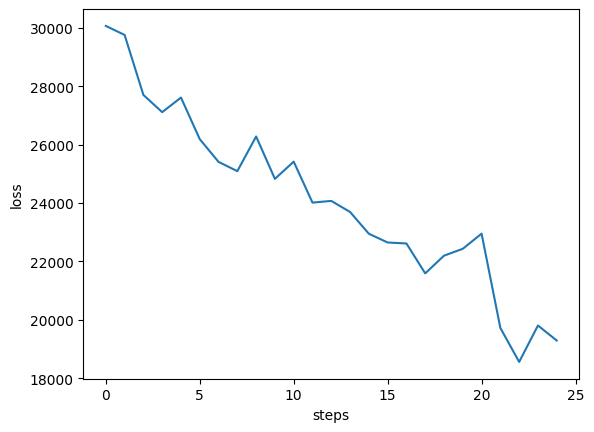

In [17]:
import matplotlib.pyplot as plt

plt.plot(loss_error)
plt.xlabel("steps")
plt.ylabel("loss")

In [ ]:
n=3
plt.plot(np.average(np.array(loss_error).reshape(-1, n), axis=1))
plt.xlabel("steps")
plt.ylabel("mse loss")

In [ ]:
preds = torch.empty(batch_size, trial_len, out_dim)

num_correct = 0
num_samples = len(test_dataset)

model.eval()


total_loss = 0
with torch.no_grad():
    for (input, output) in test_dataset:
        out, hidden_state = model(input)
        loss = criterion(out, output)
        total_loss += loss

print(f"Average test loss: {total_loss / 101}")

In [ ]:
    """for i, (input, output) in enumerate(train_dataset): # 80% of 502 different examples

        gen_output, hn = model(input)        

        loss = criterion(gen_output, output)
        nn.utils.clip_grad_norm_(model.parameters(), 1)
        def closure():
            gen_output, _ = model(input)
            loss = criterion(gen_output, output)
            loss.backward(create_graph=True)
            return loss, gen_output
        optimizer.step(closure, M_inv=None)
        # add regularization loss with rate and weights here??
        # rate by taking L2 with matrix of zeroes
        loss_error.append(loss.item())
        
        if i == 0 or (i + 1) % print_interval == 0:
            print(
                f"Epoch [{epoch + 1}/{num_epochs}], "
                f"Step [{i + 1}/{len(train_dataset)}], "
                f"Loss: {loss.item():.4f}"
            )"""

In [ ]:
model2 = MilliesRNN(in_dim, hid_dim, out_dim)

module = model2.